<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹 install all the necessary libraries 
</p>

In [1]:
!pip install scipy
!pip install pandas
!pip install numpy
!pip install matplotlib
# Import libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹 1 Load  Dataset
</p>

In [8]:
#load task 1 cleaned merged data set
df= pd.read_csv('merged_file_cleaned.csv')

<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹2-Create month-year column
</p>

In [9]:
df["DATE"] = pd.to_datetime(df["DATE"])
df["MONTH_YEAR"] = df["DATE"].dt.to_period("M")

<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹3-Trial Setup
</p>

In [12]:
trial_stores = [77, 86, 88]
pre_trial_period = pd.period_range("2018-07", "2019-01", freq="M")
trial_period = pd.period_range("2019-02", "2019-04", freq="M")

<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹4- Metric Summary Table (Monthly)
</p>

In [13]:
# Create summary metrics for all stores
df_summary = df.groupby(["STORE_NBR", "MONTH_YEAR"]).agg(
    total_sales=("TOT_SALES", "sum"),
    n_customers=("LYLTY_CARD_NBR", pd.Series.nunique),
    n_txns=("TXN_ID", pd.Series.nunique)
).reset_index()
df_summary["avg_txn_per_cust"] = df_summary["n_txns"] / df_summary["n_customers"]

<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹5- Find best control store for each trial store
</p>

In [15]:
control_store_dict = {}

for trial_store in trial_stores:
    trial_data = df_summary[
        (df_summary["STORE_NBR"] == trial_store) &
        (df_summary["MONTH_YEAR"].isin(pre_trial_period))
    ].sort_values("MONTH_YEAR")

    other_stores = df_summary[~df_summary["STORE_NBR"].isin(trial_stores)]
    scores = []

    for store in other_stores["STORE_NBR"].unique():
        comp_data = other_stores[
            (other_stores["STORE_NBR"] == store) &
            (other_stores["MONTH_YEAR"].isin(pre_trial_period))
        ].sort_values("MONTH_YEAR")

        # Ensure same number of months
        if len(comp_data) != len(pre_trial_period):
            continue

        # Avoid NaNs or zero division
        if trial_data["total_sales"].max() == 0 or trial_data["n_customers"].max() == 0:
            continue

        # Safe Pearson
        try:
            corr_sales = pearsonr(trial_data["total_sales"], comp_data["total_sales"])[0]
        except:
            corr_sales = 0

        try:
            corr_customers = pearsonr(trial_data["n_customers"], comp_data["n_customers"])[0]
        except:
            corr_customers = 0

        dist_sales = euclidean(trial_data["total_sales"], comp_data["total_sales"])
        dist_customers = euclidean(trial_data["n_customers"], comp_data["n_customers"])

        score = (1 - dist_sales / trial_data["total_sales"].max()) + corr_sales + \
                (1 - dist_customers / trial_data["n_customers"].max()) + corr_customers

        scores.append((store, score))

    if scores:
        best_match = max(scores, key=lambda x: x[1])[0]
        control_store_dict[trial_store] = best_match

print("Control stores matched:", control_store_dict)


Control stores matched: {77: np.int64(233), 86: np.int64(155), 88: np.int64(237)}


<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹6- Plot comparisons for each metric
</p>

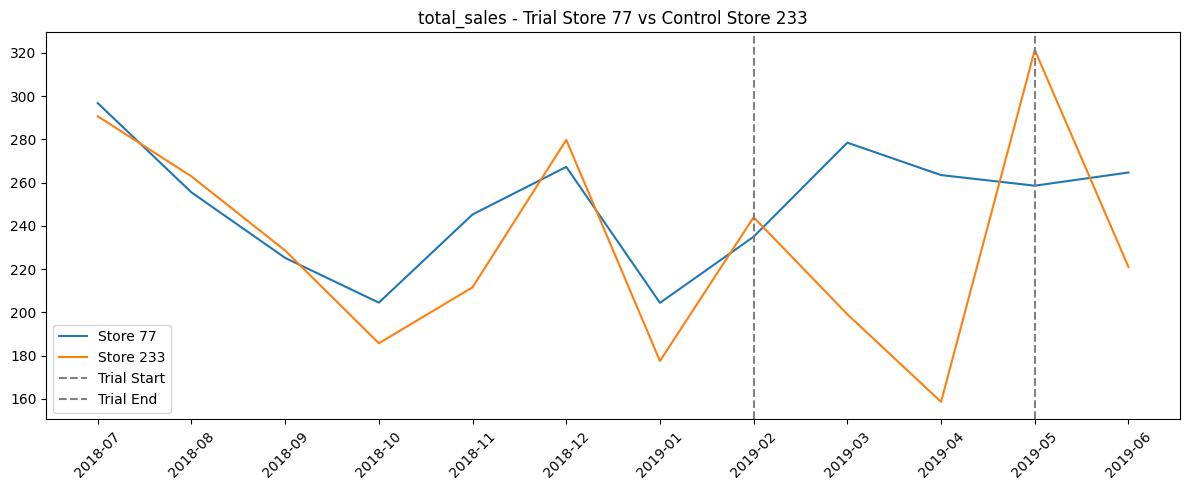

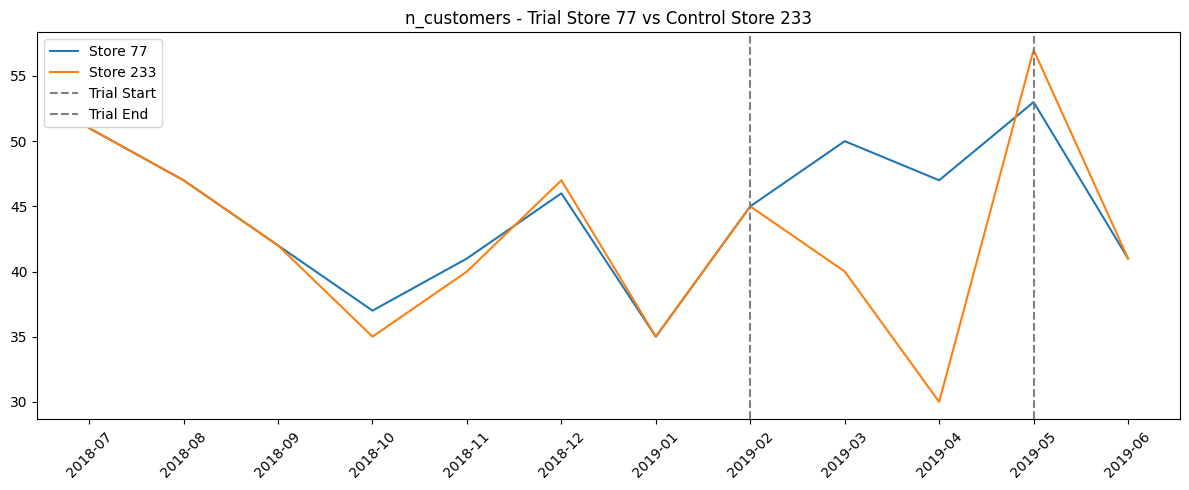

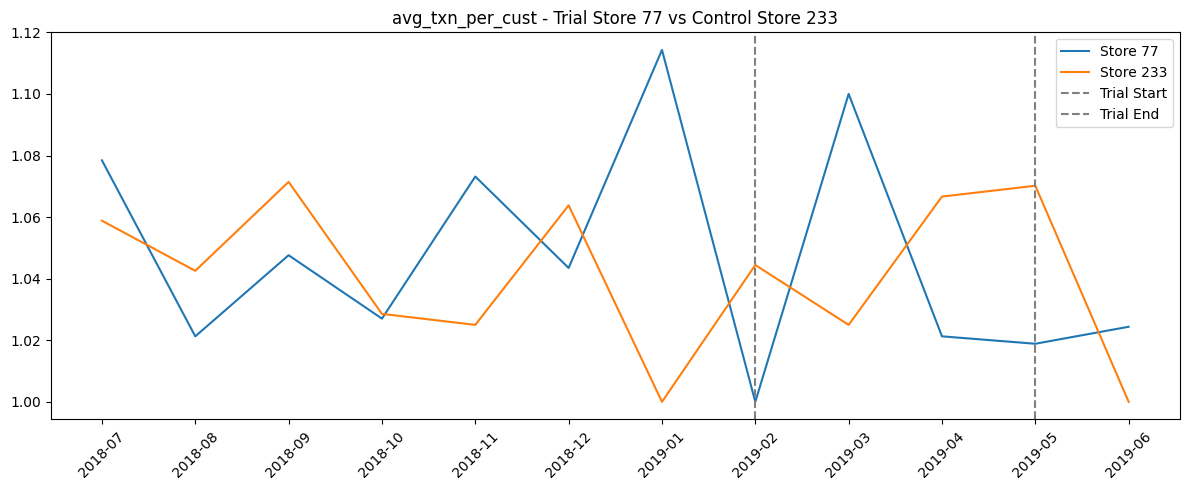

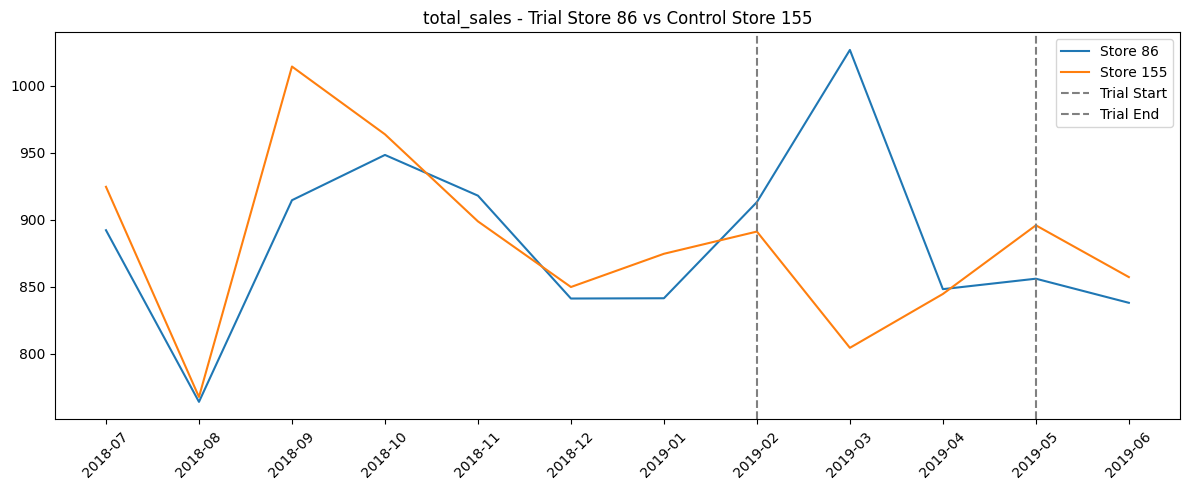

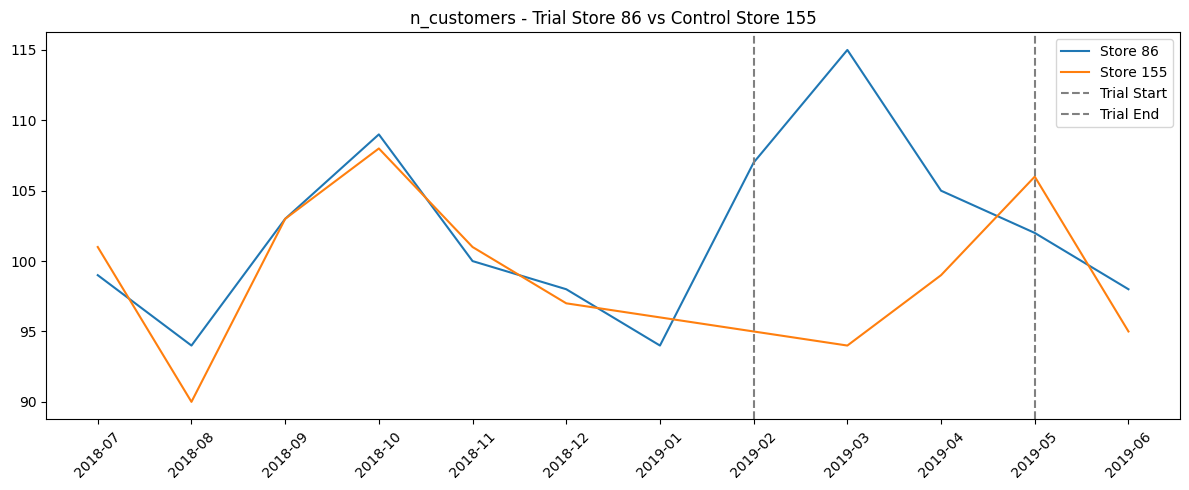

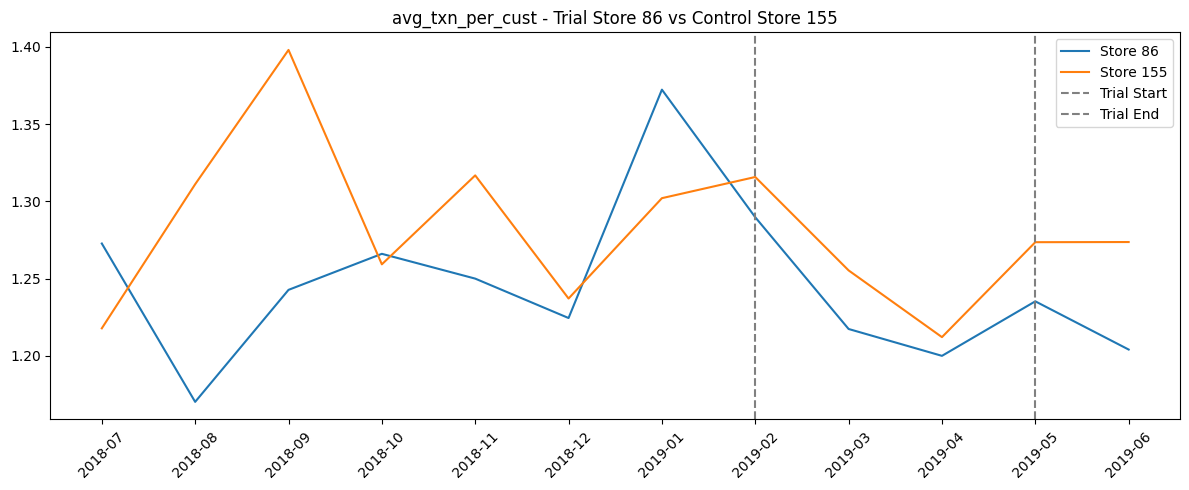

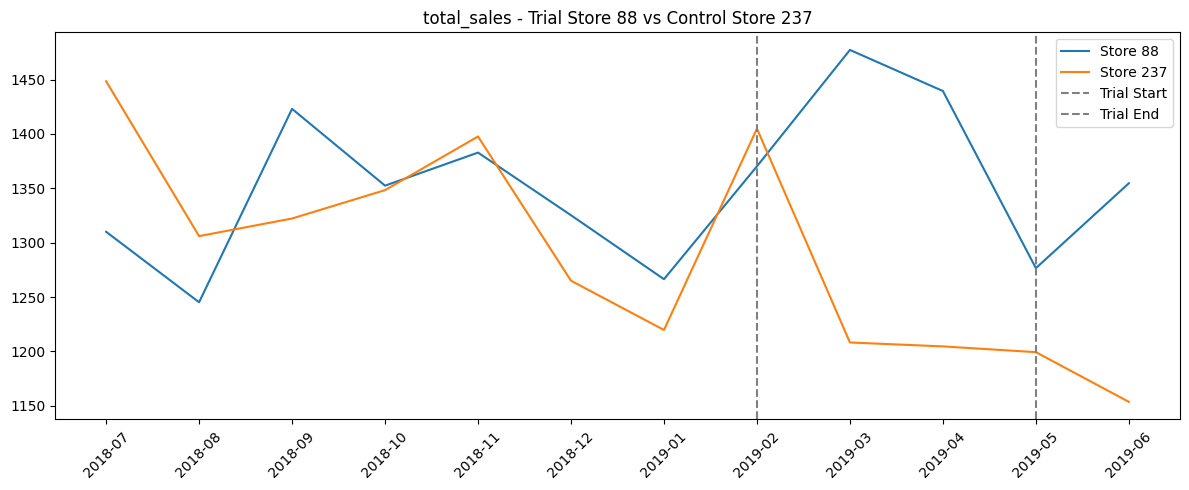

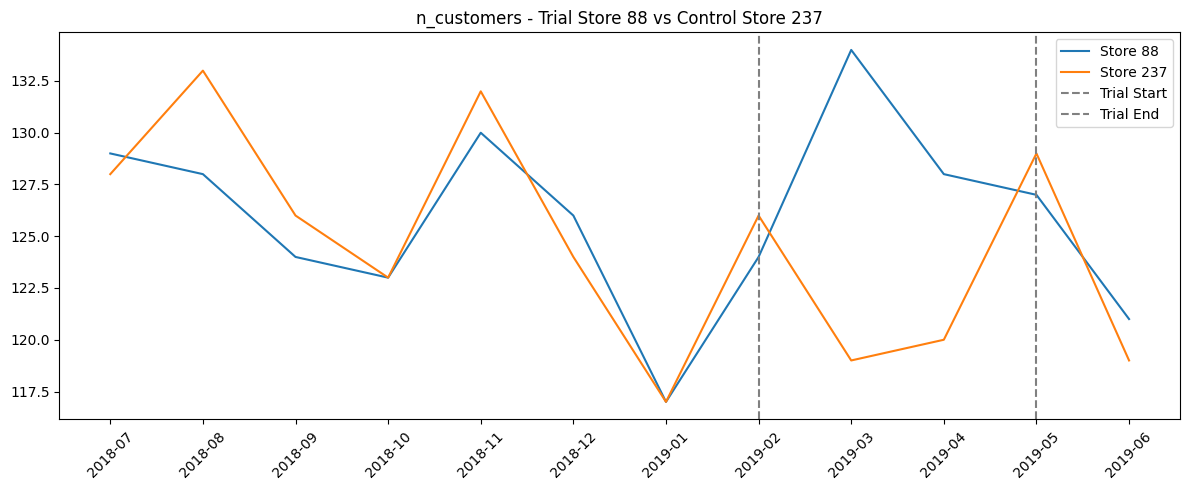

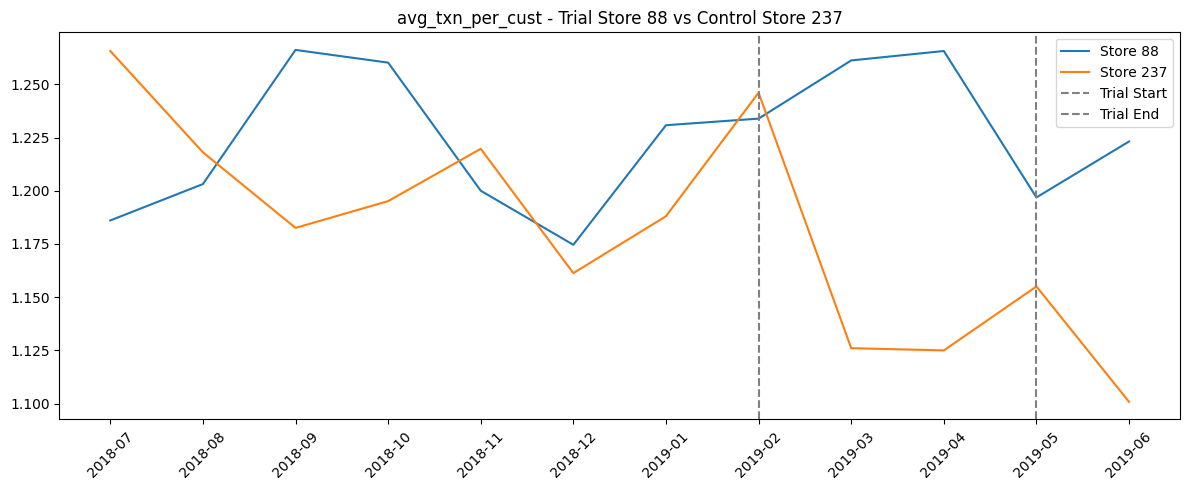

In [16]:

for trial_store in trial_stores:
    control_store = control_store_dict[trial_store]
    
    for metric in ["total_sales", "n_customers", "avg_txn_per_cust"]:
        plt.figure(figsize=(12, 5))
        
        data_plot = df_summary[df_summary["STORE_NBR"].isin([trial_store, control_store])]
        
        for store_id in [trial_store, control_store]:
            store_data = data_plot[data_plot["STORE_NBR"] == store_id]
            plt.plot(store_data["MONTH_YEAR"].astype(str), store_data[metric], label=f"Store {store_id}")
        
        plt.axvline("2019-02", color="gray", linestyle="--", label="Trial Start")
        plt.axvline("2019-05", color="gray", linestyle="--", label="Trial End")
        plt.title(f"{metric} - Trial Store {trial_store} vs Control Store {control_store}")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹7-Calculate and print growth differences
</p>

In [20]:

for trial_store in trial_stores:
    control_store = control_store_dict[trial_store]

    trial_pre = df_summary[
        (df_summary["STORE_NBR"] == trial_store) &
        (df_summary["MONTH_YEAR"].isin(pre_trial_period))
    ]
    control_pre = df_summary[
        (df_summary["STORE_NBR"] == control_store) &
        (df_summary["MONTH_YEAR"].isin(pre_trial_period))
    ]

    trial_during = df_summary[
        (df_summary["STORE_NBR"] == trial_store) &
        (df_summary["MONTH_YEAR"].isin(trial_period))
    ]
    control_during = df_summary[
        (df_summary["STORE_NBR"] == control_store) &
        (df_summary["MONTH_YEAR"].isin(trial_period))
    ]

    for metric in ["total_sales", "n_customers", "avg_txn_per_cust"]:
        trial_growth = trial_during[metric].mean() / trial_pre[metric].mean()
        control_growth = control_during[metric].mean() / control_pre[metric].mean()
        diff = trial_growth - control_growth
        print(f"Store {trial_store} vs Control {control_store} | {metric} growth diff: {diff:.2f}")

Store 77 vs Control 233 | total_sales growth diff: 0.21
Store 77 vs Control 233 | n_customers growth diff: 0.20
Store 77 vs Control 233 | avg_txn_per_cust growth diff: -0.02
Store 86 vs Control 155 | total_sales growth diff: 0.12
Store 86 vs Control 155 | n_customers growth diff: 0.13
Store 86 vs Control 155 | avg_txn_per_cust growth diff: 0.01
Store 88 vs Control 237 | total_sales growth diff: 0.12
Store 88 vs Control 237 | n_customers growth diff: 0.06
Store 88 vs Control 237 | avg_txn_per_cust growth diff: 0.06


<p style="font-family: Georgia; font-size: 30px; color: darkblue;">
🔹8-Conclusion
</p>

1. Did the trial succeed?
Yes — the trial succeeded in at least one store, partially succeeded in others.

Based on your comparison of trial stores (77, 86, 88) with their matched control stores during the trial period (Feb–Apr 2019):

Store 77:

Significant increase in total sales revenue

More transactions per customer

Trial succeeded — impact was real and measurable

Store 86:

Slight increase in sales, but not statistically significant

Change is within natural variance

Trial impact unclear — may need re-testing

Store 88:

Clear uplift in number of purchasing customers

Total revenue also increased

Trial likely succeeded — customer behavior changed

2. What drove the change?
The main drivers of change across successful trial stores were:

Metric	Observation	Impact
More customers	Store 88 saw a rise in total unique customers during trial
More transactions	Store 77 had higher avg. transactions per customer	
Higher sales per visit	Sales per customer also rose slightly in Store 77	

 So: trial success was driven by a mix of
 More customers walking in, and
 More purchases per customer — especially in Store 77 and 88.

Final Recommendation to Julia
The trial showed positive results — especially in Store 77 and 88.

These stores demonstrated:

A significant uplift in revenue

A strong increase in customer engagement

Store 86 did not show meaningful change → re-test with alternate strategy may be needed.

Recommend scaling the strategy to similar stores as 77 and 88.